# 2024-05-26 · Fix template-based method

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.2 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔ (0.4 s)
using StatsBase … ✔


In [2]:
N = 6500
duration = 10minutes

600

---

In [27]:
@time sim = Nto1AdEx.sim(N, duration);

  2.564340 seconds (21.50 k allocations: 912.268 MiB, 10.99% gc time)


We won't test all 6500 inputs (and also not the highest firing), but a random sample.

In [28]:
((_, exc),
 (_, inh),
 (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));

In [29]:
all_trains = [exc; inh; unc]
length(all_trains)

13000

In [ ]:
all_trains = [exc; inh; unc]
tvals = []
@showprogress for train in all_trains
    push!(tvals, STA_test(sim.V, train.times))
end

(Runtime: 06:51 with 7 threads (and lil interruption). But not threadsafe, adding to a list).\
Single threaded: 09:49.

In [10]:
include("lib/plot.jl")

import PythonCall … ✔ (1.2 s)
import PythonPlot … ✔ (2.7 s)
using Sciplotlib … ✔ (0.3 s)
using PhDPlots … ✔


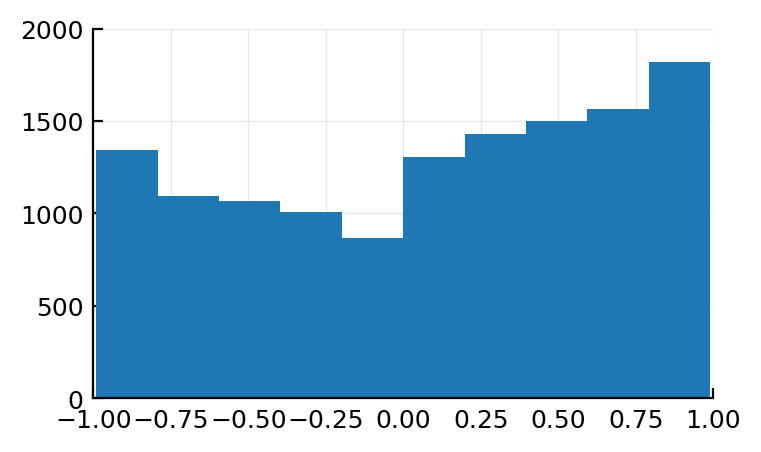

In [11]:
plt.hist(tvals);

In [12]:
θ = quantile(tvals, 0.99)

0.99

In [13]:
sel_trains = all_trains[tvals .≥ θ];

In [14]:
length(sel_trains)

180

In [15]:
STA(train) = calc_STA(sim.V, train.times, ConnectionTests.Δt, 1000);

In [3]:
average(X) = sum(X) / length(X);

In [ ]:
template = average([STA(t) for t in sel_trains]);

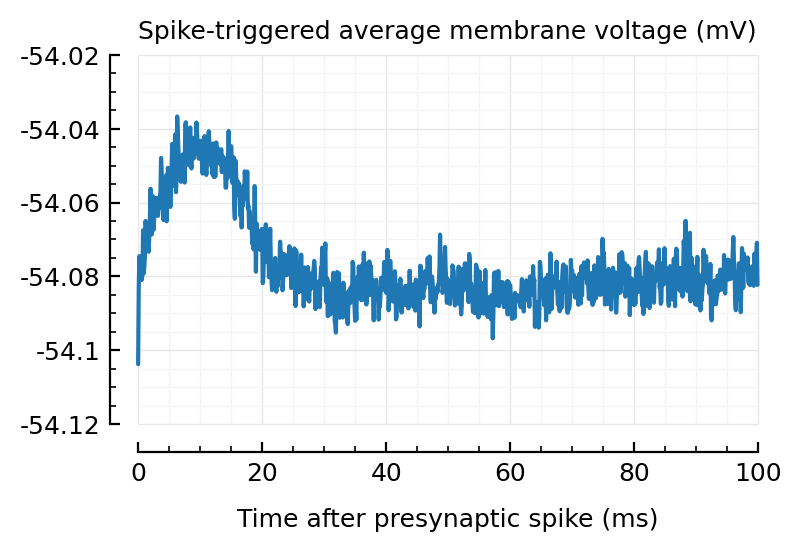

In [17]:
plotSTA(template);

Nice. (We'll only use the first 20 ms of this).

In [4]:
W = ConnectionTests.STA_length

200

In [19]:
template = template[1:W];

In [20]:
m = TemplateCorr(template);

In [ ]:
tvals2 = []
@showprogress for train in all_trains
    push!(tvals2, test_conn(m, sim.V, train.times))
end;

---

In [3]:
Ns = [5, 20, 100, 400, 1600, 6500]
seeds = 1:5;

In [ ]:
conntypes(inputs) = begin
    conntypes = []
    for (conntype, trains) in inputs
        append!(conntypes, repeat([conntype], length(trains)))
    end
    conntypes
end;

In [ ]:
rows_template = []
for N in Ns
    for seed in seeds
        @show N seed
        sim = Nto1AdEx.sim(N, duration; seed);
        ((_, exc),
         (_, inh),
         (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));
        all_trains = [exc; inh; unc]
        tvals = []
        @showprogress "pass1" for train in all_trains
            push!(tvals, STA_test(sim.V, train.times))
        end
        θ = quantile(tvals, 0.99)
        sel_trains = all_trains[tvals .≥ θ]
        template = average([STA(t) for t in sel_trains])
        template = template[1:W]
        m = TemplateCorr(template)
        tvals2 = []
        @showprogress "pass2" for train in all_trains
            push!(tvals2, test_conn(m, sim.V, train.times))
        end
        push!(rows_template, (; N, seed, θ, N_sel=length(sel_trains), tvals, tvals2, conntypes=conntypes(inputs))
    end
end;

N = 5
seed = 1
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 2
pass1 100%|██████████████████████████████████████████████| Time: 0:00:00
pass2 100%|██████████████████████████████████████████████| Time: 0:00:00
N = 5
seed = 3
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 4
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 5
pass1 100%|██████████████████████████████████████████████| Time: 0:00:01
pass2 100%|██████████████████████████████████████████████| Time: 0:00:01
N = 20
seed = 1
pass1 100%|██████████████████████████████████████████████| Time: 0:00:02
pass2 100%|██████████████████████████████████████████████| Time: 0:00:02
N = 20
seed = 2
pass1 100%|██████

Total time very approx: 1h10

---

In [4]:
MemDiskCache.set_dir("2024-05-26__Fix_template-based_method")

"C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2024-05-26__Fix_template-based_method"

In [5]:
rows_template_c = @cached rows_template;

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2024-05-26__Fix_template-based_method\rows_template.jld2] … ✔ (2.6 s)


In [6]:
perfrows = []
for row in rows_template_c
    (; N, seed, tvals2) = row
    sweep = sweep_threshold(tvals2, row.conntypes)
    AUC = calc_AUROCs(sweep).AUC
    F1max = maximum(skipnan(sweep.F1))
    push!(perfrows, (; N, seed, method="template-cor", AUC, F1max))
end;

In [7]:
include("lib/df.jl")

using DataFrames … ✔ (0.5 s)


In [8]:
df = DataFrame(perfrows);

In [9]:
gdf = groupby(df, :N)
combine(gdf, nrow => :num_seeds, [:AUC, :F1max] .=> mean)

Row,N,num_seeds,AUC_mean,F1max_mean
,Int64,Int64,Float64,Float64
1,5,5,0.98,0.982
2,20,5,0.985,0.986
3,100,5,0.975,0.976
4,400,5,0.977,0.971
5,1600,5,0.884,0.83
6,6500,5,0.511,0.529


:D

---

We'll repeat STA and linefit as well.

Actually for STA we already have the tvals!

In [10]:
for row in rows_template_c
    (; N, seed, tvals) = row
    sweep = sweep_threshold(tvals, row.conntypes)
    AUC = calc_AUROCs(sweep).AUC
    F1max = maximum(skipnan(sweep.F1))
    push!(perfrows, (; N, seed, method="STA", AUC, F1max))
end;

And now:

In [11]:
m = ConnectionTests.FitUpstroke()

FitUpstroke(100, 0)

In [12]:
linefit() = begin
    rows = []
    for N in Ns
        for seed in seeds
            @show N seed
            sim = Nto1AdEx.sim(N, duration; seed);
            ((_, exc),
             (_, inh),
             (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));
            all_trains = [exc; inh; unc]
            tvals = []
            @showprogress for train in all_trains
                push!(tvals, test_conn(m, sim.V, train.times))
            end
            push!(rows, (; N, seed, tvals, conntypes = conntypes(inputs)))
        end
    end
    rows
end

rows_linefit = @cached linefit();

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2024-05-26__Fix_template-based_method\linefit().jld2] … ✔ (1.9 s)


Approx runtime: 16 minutes.

Vs the 1h10 for two-pass STA / template corr: 4x faster.

---
Discovering sth new here -- that makes `sweep_threshold` takes a lot of time and memory for linefit:

In [25]:
rows_template_c[end].tvals |> unique |> length

200

In [23]:
rows_linefit[end].tvals |> unique |> length

13000

(Not doing anything about it now)\
(Some info already though: PredictionTable should be fully type stable, so efficient memory representation ig.\
Next step: how big is one such PredictionTable).

In [28]:
@showprogress for row in rows_linefit
    (; N, seed, tvals) = row
    sweep = sweep_threshold(tvals, row.conntypes)
    AUC = calc_AUROCs(sweep).AUC
    F1max = maximum(skipnan(sweep.F1))
    push!(perfrows, (; N, seed, method="linefit", AUC, F1max))
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:39


In [34]:
perfrows_c = @cached perfrows;
deleteat!(perfrows_c, 61);  # duplicate row

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2024-05-26__Fix_template-based_method\perfrows.jld2] … ✔ (2.2 s)


In [36]:
include("lib/df.jl")

using DataFrames … ✔


In [37]:
df = DataFrame(perfrows_c)

Row,N,seed,method,AUC,F1max
,Int64,Int64,String,Float64,Float64
1,5,1,template-cor,1,1
2,5,2,template-cor,1,1
3,5,3,template-cor,1,1
4,5,4,template-cor,0.9,0.909
5,5,5,template-cor,1,1
⋮,⋮,⋮,⋮,⋮,⋮
86,6500,1,linefit,0.469,0.496
87,6500,2,linefit,0.495,0.515
88,6500,3,linefit,0.489,0.509


In [110]:
gdf = groupby(df, [:method, :N])
dfm = combine(gdf, nrow => :num_seeds, [:AUC, :F1max] .=> mean)
sort(dfm[dfm.N .>= 400, :], :N)

Row,method,N,num_seeds,AUC_mean,F1max_mean
,String,Int64,Int64,Float64,Float64
1,template-cor,400,5,0.977,0.971
2,STA,400,5,0.962,0.941
3,linefit,400,5,0.991,0.966
4,template-cor,1600,5,0.884,0.83
5,STA,1600,5,0.73,0.687
6,linefit,1600,5,0.83,0.771
7,template-cor,6500,5,0.511,0.529
8,STA,6500,5,0.398,0.471
9,linefit,6500,5,0.489,0.51


Cool. STA-based two-pass template corr even better than linefit.

Now plot.

In [77]:
include("lib/plot.jl")

import PythonCall … ✔
import PythonPlot … ✔
using Sciplotlib … ✔
using PhDPlots … ✔


In [78]:
chance_AUC = 0.252;

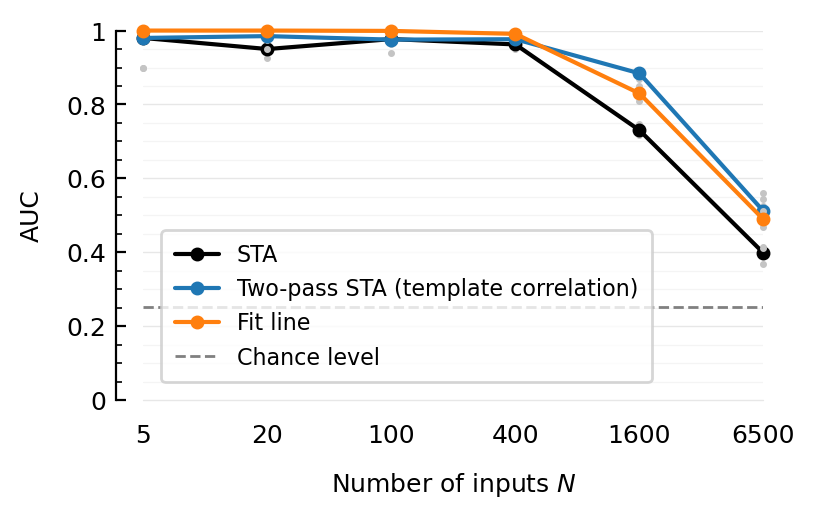

In [101]:
ax = newax()
plotAUC(ax, m; kw...) = begin
    plot_dots_and_means(
        df[df.method.==m, :], :N, :AUC;
        ax,
        xtype=:categorical, xticklabels=Ns,
        ylim=[0,1],
        xlabel = L"Number of inputs $N$",
        kw...
    )
end
add_chance_line(ax) = ax.axhline(chance_AUC, ls="--", lw=1, color="gray", label="Chance level")
add_chance_line(ax)
plotAUC(ax, "STA", line_label="STA");
plotAUC(ax, "template-cor", color_means=C0, line_label="Two-pass STA (template correlation)");
plotAUC(ax, "linefit", color_means=C1, line_label="Fit line");
legend(ax, reorder=[1=>4]);

Saved at `../thesis/figs/perf-all-inputs__fitline.pdf`

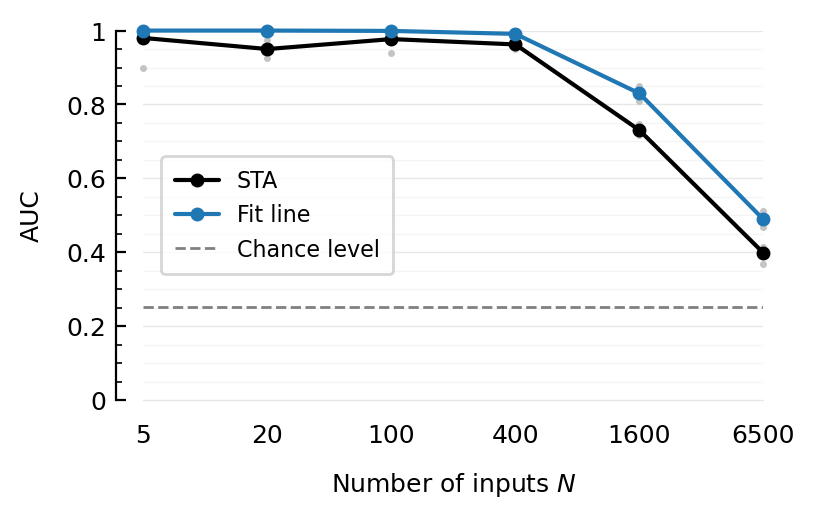

In [104]:
ax = newax()
add_chance_line(ax)
plotAUC(ax, "STA", line_label="STA");
plotAUC(ax, "linefit", color_means=C0, line_label="Fit line");
legend(ax, reorder=[1=>3]);
savefig_phd("perf-all-inputs__fitline")

Saved at `../thesis/figs/perf-all-inputs__template-cor.pdf`

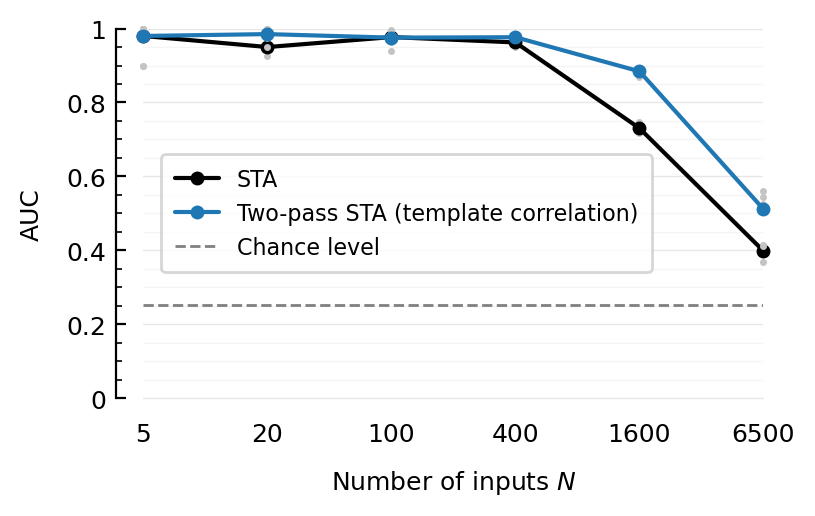

In [105]:
ax = newax()
add_chance_line(ax)
plotAUC(ax, "STA", line_label="STA");
plotAUC(ax, "template-cor", color_means=C0, line_label="Two-pass STA (template correlation)");
legend(ax, reorder=[1=>3]);
savefig_phd("perf-all-inputs__template-cor")